In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process DTI and free water DTI
import dipy.reconst.dti as dti
import dipy.reconst.fwdti as fwdti

In [13]:
# function to compute residuals for different f-values

def wiper_residuals(gtab, sig, S0, min_signal=1.0e-6, Diso=3e-3):
    """ This function computes the residuals of the fw DTI model"""
    params = np.zeros(sig.shape[:-1] + (3,))

    # Define design matrix
    bmag = int(np.log10(gtab.bvals.max()))
    b = gtab.bvals.copy() / (10 ** (bmag-1))  # normalize b units
    b = b.round() * (10 ** (bmag-1))
    uniqueb = np.unique(b)
    nb = len(uniqueb)

    B = np.zeros((nb, 3))
    B[:, 0] = -uniqueb
    B[:, 1] = 1.0/6.0 * uniqueb**2
    B[:, 2] = np.ones(nb)

    ng = np.zeros(nb)
    for bi in range(nb):
        ng[bi] = np.sum(b == uniqueb[bi])
    ng = np.sqrt(ng)
    
    # When addapting this to multivoxel this is the part
    # that should be repeated voxel by voxel
    msig = np.zeros(nb)
    for bi in range(nb):
        msig[bi] = np.mean(sig[b == uniqueb[bi]])

    # Define weights as diag(sqrt(ng) * yn**2)
    W = np.diag(ng * msig**2)
    
    # DTI weighted linear least square solution
    BTW = np.dot(B.T, W)
    inv_BT_W_B = np.linalg.pinv(np.dot(BTW, B))
    invBTWB_BTW = np.dot(inv_BT_W_B, BTW)
    p = np.dot(invBTWB_BTW, np.log(msig))

    # General free-water signal contribution
    fwsig = np.exp(np.dot(B, np.array([Diso, 0, 0])))

    df = 0.01  # initialize precision
    flow = 0.01  # lower f evaluated
    fhig = 0.99  # higher f evaluated
    ns = 99  # number of f samples 
    fs = np.linspace(flow, fhig, num=ns)  # sampling f
    SFW = np.array([fwsig, ]*ns)  # repeat contributions for all values
    FS, SI = np.meshgrid(fs, msig)
    SA = SI - FS*S0*SFW.T
    # SA < 0 means that the signal components from the free water
    # component is larger than the total fiber. This cases are present
    # for inapropriate large volume fractions (given the current S0
    # value estimated). To overcome this issue negative SA are replaced
    # by data's min positive signal.
    SA[SA <= 0] = min_signal
    y = np.log(SA / (1-FS))
    all_new_params = np.dot(invBTWB_BTW, y)

    # Select params for lower F2
    SIpred = (1-FS)*np.exp(np.dot(B, all_new_params)) + FS*S0*SFW.T
    F2 = np.sum(np.square(SI - SIpred), axis=0)
    return F2 / 0.5

In [8]:
# function to compute residuals for different f-values

def fwdti_residuals_rnh(sig, S0, design_matrix, min_signal=1.0e-6,
                           Diso=3e-3):
    """ This function computes the residuals of the fw DTI model"""
    W = design_matrix

    # DTI ordinary linear least square solution
    log_s = np.log(np.maximum(sig, min_signal))

    # Define weights first guess
    params = np.dot(np.linalg.pinv(W), log_s)
    S2 = np.diag(np.exp(2 * np.dot(W, params)))
    
    # DTI weighted linear least square solution
    WTS2 = np.dot(W.T, S2)
    inv_WT_S2_W = np.linalg.pinv(np.dot(WTS2, W))
    invWTS2W_WTS2 = np.dot(inv_WT_S2_W, WTS2)
    params = np.dot(invWTS2W_WTS2, log_s)

    # Refine weights
    S2 = np.diag(np.exp(2 * np.dot(W, params)))

    md = (params[0] + params[2] + params[5]) / 3
    # Process voxel if it has significant signal from tissue

    # General free-water signal contribution
    fwsig = np.exp(np.dot(design_matrix,
                          np.array([Diso, 0, Diso, 0, 0, Diso, 0])))

    df = 0.01  # initialize precision
    flow = 0.01  # lower f evaluated
    fhig = 0.99  # higher f evaluated
    ns = 99  # number of f samples 
    fs = np.linspace(flow, fhig, num=ns)  # sampling f
    SFW = np.array([fwsig, ]*ns)  # repeat contributions for all values
    FS, SI = np.meshgrid(fs, sig)
    SA = SI - FS*S0*SFW.T
    # SA < 0 means that the signal components from the free water
    # component is larger than the total fiber. This cases are present
    # for inapropriate large volume fractions (given the current S0
    # value estimated). To overcome this issue negative SA are replaced
    # by data's min positive signal.
    SA[SA <= 0] = min_signal
    y = np.log(SA / (1-FS))
    all_new_params = np.dot(invWTS2W_WTS2, y)
    # Select params for lower F2
    SIpred = (1-FS)*np.exp(np.dot(W, all_new_params)) + FS*S0*SFW.T
    F2 = np.sum(np.square(SI - SIpred), axis=0)
    return F2 / 0.5

In [26]:
SNR = np.array([10., 20., 30., 40., 50.])

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvals = np.hstack((np.zeros(6),
                   500 * np.ones(n_pts),
                   1000 * np.ones(n_pts),
                   1500 * np.ones(n_pts),
                   2000 * np.ones(n_pts),
                   2500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)),
                   directions,
                   directions,
                   directions,
                   directions,
                   directions))
gtab = gradient_table(bvals, bvecs)

In [27]:
# free water component
VF = 50
Dwater = 3e-3

# tissue component
FA = np.array([0.71, 0.11])
L1 = np.array([1.6e-3, 0.900e-3])
L2 = np.array([0.5e-3, 0.763e-3])
L3 = np.array([0.3e-3, 0.738e-3])

# simulations are repeated for 120 different diffusion tensor's
# directions
nDTdirs = 120
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices  # directions for each shell
nrep = 100

In [28]:
DWI_simulates = np.empty((FA.size, SNR.size, nrep * nDTdirs,
                          bvals.size))
fractions = [100 - VF, VF]

count_i = 1.0;

for fa_i in range(FA.size):
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])
    for snr_i in range(SNR.size):
        this_snr = SNR[snr_i]
        for di in range(nDTdirs):
            d = DTdirs[di]
            for s_i in np.arange(di * nrep, (di+1) * nrep):
                signal, sticks = multi_tensor(gtab, mevals,
                                              S0=100,
                                              angles=[d, (1, 0, 0)],
                                              fractions=fractions,
                                              snr=this_snr)
                DWI_simulates[fa_i, snr_i, s_i, :] = signal
        prog = count_i / (SNR.size * FA.size) * 100
        count_i = count_i + 1.0
        time.sleep(1)
        sys.stdout.write("\r%f%%" % prog)
        sys.stdout.flush()

100.000000%

In [56]:
df = 0.01  # initialize precision
flow = 0.01  # lower f evaluated
fhig = 0.99  # higher f evaluated
ns = 99  # number of f samples 
fs = np.linspace(flow, fhig, num=ns) 

dm = dti.design_matrix(gtab)
Residual_curves = np.zeros((FA.size, SNR.size, 99))
f_min_res = np.zeros((FA.size, SNR.size, nrep * nDTdirs))
S0 = np.mean(DWI_simulates[:, :, :, gtab.b0s_mask], axis=-1)
count_i = 1.0
for fa_i in range(FA.size):
    for snr_i in range(SNR.size):
        for di in range(nrep * nDTdirs):
            rcurve_i = fwdti_residuals_rnh(DWI_simulates[fa_i, snr_i, di], S0[fa_i, snr_i, di], dm)
            Residual_curves[fa_i, snr_i] = Residual_curves[fa_i, snr_i] + rcurve_i
            Mind = np.argmin(rcurve_i)
            f_min_res[fa_i, snr_i, di] = fs[Mind]
        prog = count_i / (SNR.size * FA.size) * 100
        count_i = count_i + 1.0
        time.sleep(1)
        sys.stdout.write("\r%f%%" % prog)
        sys.stdout.flush()
Residual_curves = Residual_curves / nDTdirs

100.000000%

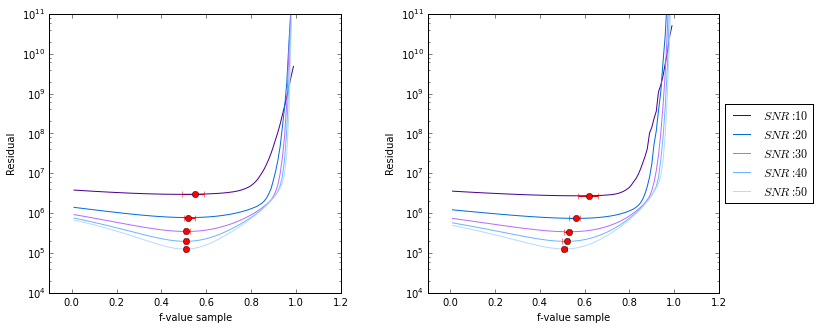

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

colors = {0: [73.0/255, 0, 146.0/255],
          1: [0, 109.0/255, 219.0/255],
          2: [182.0/255, 109.0/255, 255.0/255],
          3: [109.0/255, 182.0/255, 255.0/255],
          4: [182.0/255, 219.0/255, 255.0/255]}

median_f = np.empty(SNR.size)
lower_p = np.empty(SNR.size)
upper_p = np.empty(SNR.size)
y = np.empty(SNR.size)

for fa_i in range(FA.size):
    axs[fa_i].set_xlim([-0.1, 1.2])
    for snr_i in range(SNR.size):
        median_f[snr_i] = np.median(f_min_res[fa_i, snr_i, :])
        p5, p95 = np.percentile(f_min_res[fa_i, snr_i, :], [25 ,75])
        lower_p[snr_i] = median_f[snr_i] - p5 
        upper_p[snr_i] = p95 - median_f[snr_i]
        axs[fa_i].semilogy(fs, Residual_curves[fa_i, snr_i],
                           color=colors[snr_i],
                           linewidth=1.0,
                           label='$SNR: %.0f$' % SNR[snr_i])
        y[snr_i] = Residual_curves[fa_i, snr_i, round(median_f[snr_i]*100)]
    axs[fa_i].errorbar(median_f, y, xerr=[lower_p, upper_p],
                       fmt='o', color='r', ecolor='r')
    axs[fa_i].set_xlabel('f-value sample')
    axs[fa_i].set_ylabel('Residual')
    axs[fa_i].set_ylim([10e3, 10e10])
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('fwdti_wlsF2_weights_signal_5b-values.png', dpi=1000)

In [31]:
df = 0.01  # initialize precision
flow = 0.01  # lower f evaluated
fhig = 0.99  # higher f evaluated
ns = 99  # number of f samples 
fs = np.linspace(flow, fhig, num=ns) 

dm = dti.design_matrix(gtab)
Residual_curves = np.zeros((FA.size, SNR.size, 99))
f_min_res = np.zeros((FA.size, SNR.size, nrep * nDTdirs))
S0 = np.mean(DWI_simulates[:, :, :, gtab.b0s_mask], axis=-1)
count_i = 1.0
for fa_i in range(FA.size):
    for snr_i in range(SNR.size):
        for di in range(nrep * nDTdirs):
            rcurve_i = wiper_residuals(gtab, DWI_simulates[fa_i, snr_i, di], S0[fa_i, snr_i, di])
            Residual_curves[fa_i, snr_i] = Residual_curves[fa_i, snr_i] + rcurve_i
            Mind = np.argmin(rcurve_i)
            f_min_res[fa_i, snr_i, di] = fs[Mind]
        prog = count_i / (SNR.size * FA.size) * 100
        count_i = count_i + 1.0
        time.sleep(1)
        sys.stdout.write("\r%f%%" % prog)
        sys.stdout.flush()
Residual_curves = Residual_curves / nDTdirs

100.000000%

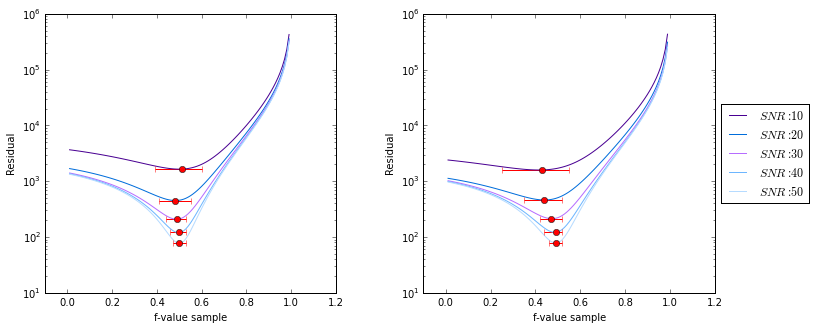

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

colors = {0: [73.0/255, 0, 146.0/255],
          1: [0, 109.0/255, 219.0/255],
          2: [182.0/255, 109.0/255, 255.0/255],
          3: [109.0/255, 182.0/255, 255.0/255],
          4: [182.0/255, 219.0/255, 255.0/255]}

median_f = np.empty(SNR.size)
lower_p = np.empty(SNR.size)
upper_p = np.empty(SNR.size)
y = np.empty(SNR.size)

for fa_i in range(FA.size):
    axs[fa_i].set_xlim([-0.1, 1.2])
    for snr_i in range(SNR.size):
        median_f[snr_i] = np.median(f_min_res[fa_i, snr_i, :])
        p5, p95 = np.percentile(f_min_res[fa_i, snr_i, :], [25 ,75])
        lower_p[snr_i] = median_f[snr_i] - p5 
        upper_p[snr_i] = p95 - median_f[snr_i]
        axs[fa_i].semilogy(fs, Residual_curves[fa_i, snr_i],
                           color=colors[snr_i],
                           linewidth=1.0,
                           label='$SNR: %.0f$' % SNR[snr_i])
        y[snr_i] = Residual_curves[fa_i, snr_i, round(median_f[snr_i]*100)]
    axs[fa_i].errorbar(median_f, y, xerr=[lower_p, upper_p],
                       fmt='o', color='r', ecolor='r')
    axs[fa_i].set_xlabel('f-value sample')
    axs[fa_i].set_ylabel('Residual')
    #axs[fa_i].set_ylim([1.0e4, 1.0e11])
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('fwdti_wiper_residual_no_tissue_heterogeneity_5b_p.png', dpi=1000)

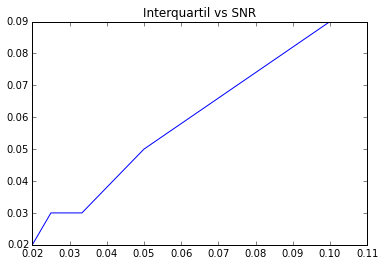

In [55]:
plt.figure()
plt.errorbar(1.0/SNR, upper_p + lower_p)
plt.title("Interquartil vs SNR")

In [54]:
upper_p + lower_p

array([ 0.09,  0.05,  0.03,  0.03,  0.02])

In [43]:
1.0/SNR

array([ 0.1       ,  0.05      ,  0.03333333,  0.025     ,  0.02      ])